In [1]:
!pip install kaggle

# **1. Download the Dataset from kaggle**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonytherrien/image-classification-64-classes-animal")

print("Path to dataset files:", path)

100%|██████████| 5.71G/5.71G [01:13<00:00, 83.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anthonytherrien/image-classification-64-classes-animal/versions/1


In [3]:
!kaggle datasets download -d anthonytherrien/image-classification-64-classes-animal

Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/image-classification-64-classes-animal
License(s): CC-BY-SA-4.0
100% 5.71G/5.71G [00:55<00:00, 157MB/s]
100% 5.71G/5.71G [00:55<00:00, 110MB/s]


**1.1 Extracting the zipFile**

In [4]:
import zipfile
with zipfile.ZipFile('/content/image-classification-64-classes-animal.zip') as zepfile:
  zepfile.extractall("animal-classification")

In [5]:
#Folders in dataset
import os

Dataset = "animal-classification/image"
folders = os.listdir(Dataset)
print("Folders in dataset:", folders)

Folders in dataset: ['duck', 'antelope', 'goat', 'snail', 'koala', 'ferret', 'ostrich', 'walrus', 'mongoose', 'goose', 'porcupine', 'chinchilla', 'penguin', 'lynx', 'owl', 'hawk', 'iguana', 'frog', 'crab', 'falcon', 'cow', 'jaguar', 'spider', 'camel', 'gorilla', 'cheetah', 'lemur', 'deer', 'squid', 'butterfly', 'hippopotamus', 'blackbird', 'eagle', 'mole', 'raccoon', 'hedgehog', 'crocodile', 'peacock', 'kangaroo', 'dog', 'wolf', 'bee', 'fox', 'otter', 'seal', 'giraffe', 'dolphin', 'grasshopper', 'whale', 'elephant', 'beaver', 'bear', 'cat', 'lizard', 'sheep', 'chimpanzee', 'leopard', 'snake', 'bison', 'buffalo', 'panda', 'hyena', 'donkey', 'flamingo']


# **2. Load necessary Libraries**

In [6]:
import numpy as np #used to stire the image pixel to array
import tensorflow as tf #used to build the CNN model
from tensorflow.keras.utils import to_categorical #convert the class labels into one-hot-encoded format
from tensorflow.keras import models,layers #Layers for CNN Architecture
from tensorflow.keras.models import Sequential #To define the sequential model



In [7]:
from sklearn.model_selection import train_test_split #split the dataset for training, validation and testing
import matplotlib.pyplot as plt #To visualize the result

In [8]:
import cv2 #To handel the images(e.g., resizing and preprocessing)

In [9]:
CHANNELS = 3
EPOCHS = 20

IMAGE_SIZE = 224
BATCH_SIZE = 32

# **3. Load and Preprocess the Dataset**

In [10]:

Datasets=tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/animal-classification/image',
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 14377 files belonging to 64 classes.


In [11]:
class_names = Datasets.class_names


In [12]:
len(Datasets)

450

In [13]:
for image_batch,label_batch in Datasets.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 224, 224, 3)
[25 16  6 15  0 60 33 51 45 50 30  4  3 43  5 32 13 52 21 14 52 11 37 49
 62 22 49 20  2 33 43  9]


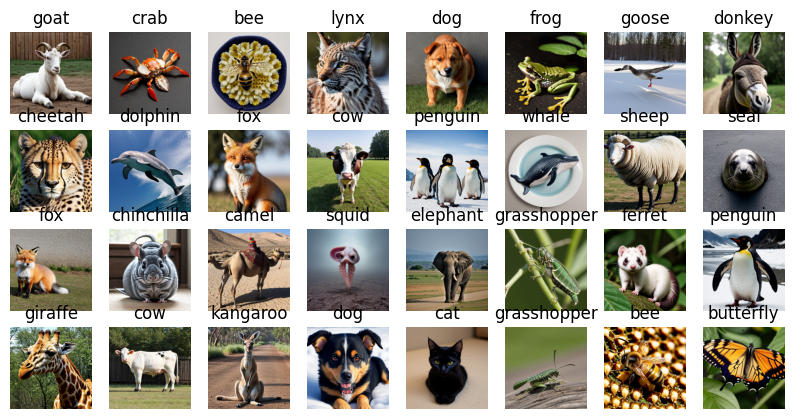

In [14]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in Datasets.take(1):
  #print(image_batch[0].numpy())
  #print(image_batch[0].shape)
  for i in range(image_batch.shape[0]): # Change the range to the actual number of images in the batch
    ax = plt.subplot(8,8,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off") # Hide the axis

# **4. Split the Dataset to Train, Test and validation**

**4.1 Dataset divided to three parts**

1. Train Dataset - 0.8 (80%)
2. Test Dataset - 0.1 (10%)
3. Valid Dataset - 0.1 (10%)

In [15]:
def get_dataset_partitions_tf(data, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 15000):
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * data_size)
  validation_size = int(validation_split * data_size)

  train_dataset = data.take(train_size)
  validation_dataset = data.skip(train_size).take(validation_size)
  test_dataset = data.skip(train_size).skip(validation_size)

  return train_dataset, validation_dataset, test_dataset



In [16]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(Datasets)

In [17]:
len(train_dataset)

360

In [18]:
len(test_dataset)

45

In [19]:
len(validation_dataset)

45

In [20]:
#Shuffle the data
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
#Resize the image
img_resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [22]:
Data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# **5. Define the CNN Model**

In [23]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 64

model= models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    img_resize_and_rescale,
    Data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,120 (84.92 MB)

 Trainable params: 22,261,120 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_dataset
)

Epoch 1/20
305/360 ━━━━━━━━━━━━━━━━━━━━ 3:56 4s/step - accuracy: 0.0447 - loss: 4.1187

KeyboardInterrupt: 

In [29]:
import tensorflow as tf

# Check if GPU is available
gpu_list = tf.config.list_physical_devices('GPU')
if gpu_list:
    gpu_info = tf.config.experimental.get_memory_info('GPU:0')
    print(f"GPU Available: {gpu_list}")
    print(f"Total GPU Memory: {gpu_info['current']} MB")
else:
    print("No GPU found. Running on CPU.")


No GPU found. Running on CPU.
